## Data Exploration

In [3]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

bundle = torchaudio.pipelines.WAV2VEC2_LARGE
model_extr = bundle.get_model().to(device)

1.12.1
0.12.1+cu113
cuda


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /home/wawa_/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [90]:
sample_file = '/home/wawa_/CaFE/Low resolution (48kHz)/Colère/Fort/01-C-2-1.wav'
sample_wave, sr = torchaudio.load(sample_file)

In [91]:
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

In [93]:
with torch.inference_mode():
    features, _ = model_extr.extract_features(sample_wave)

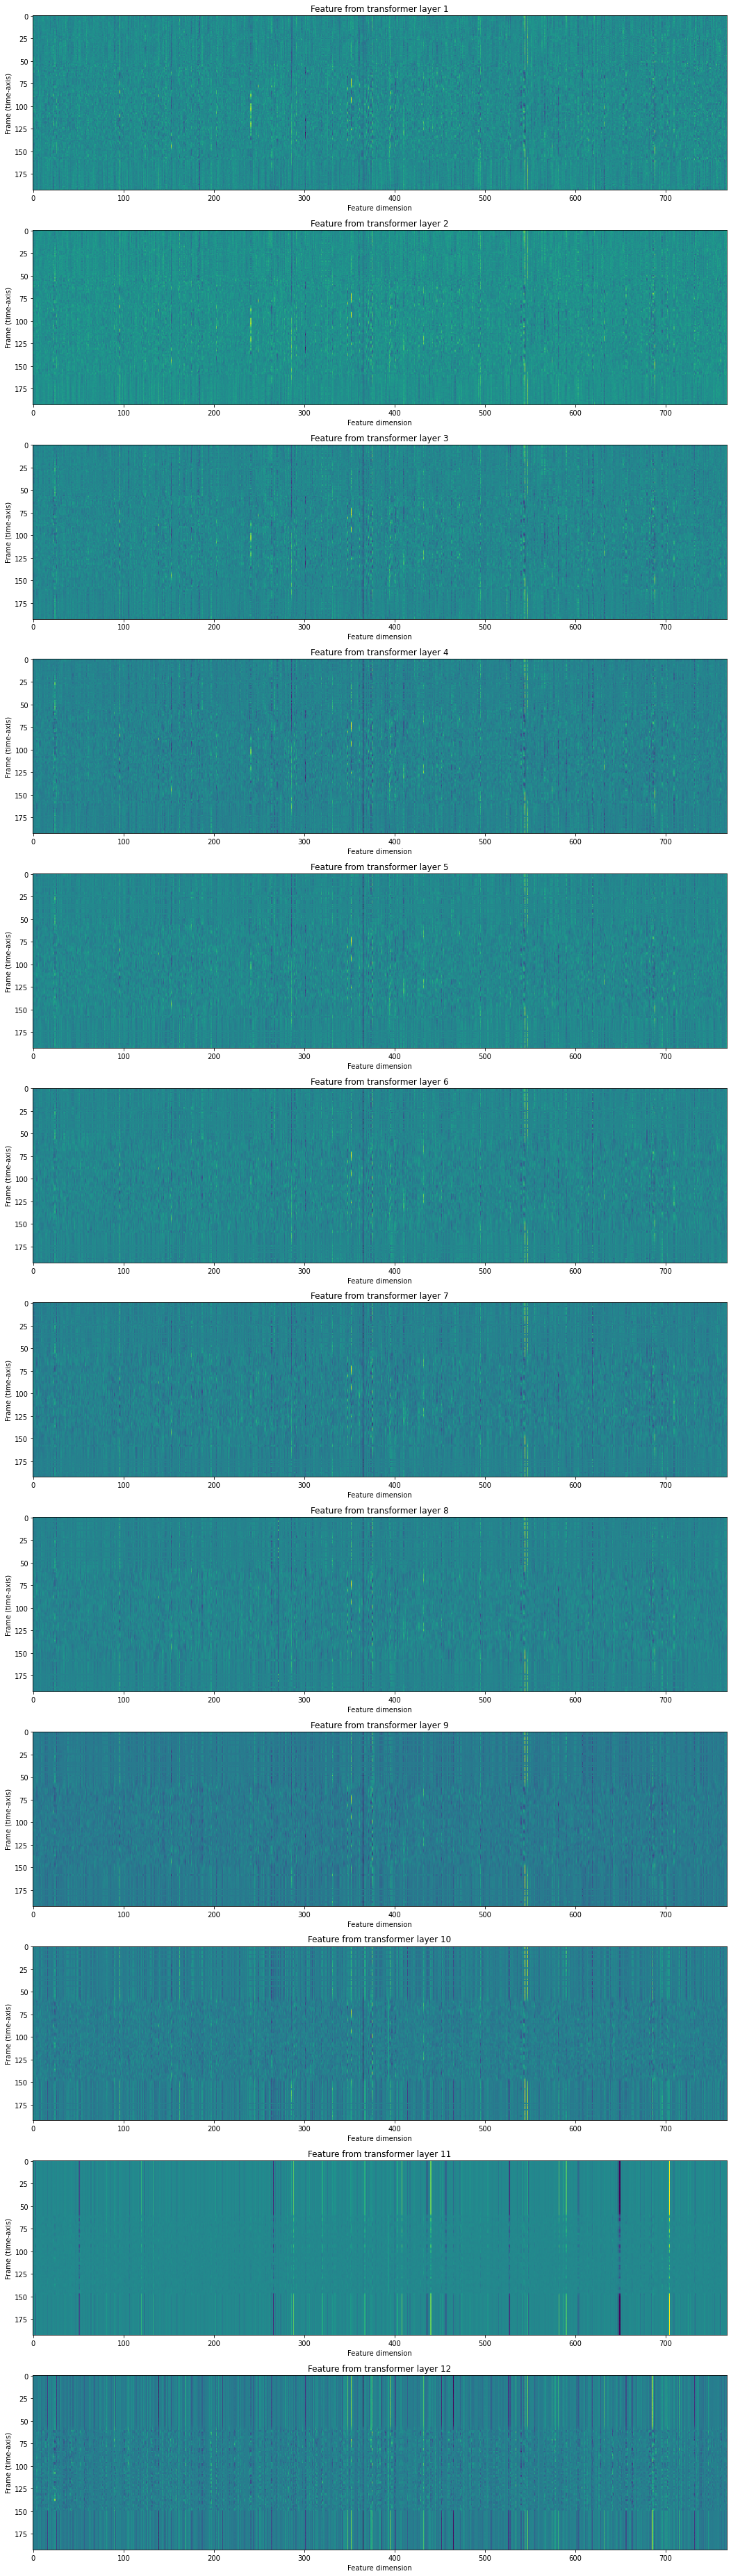

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(audios[0]), 1, figsize=(16, 4.3 * len(audios[0])))
for i, feats in enumerate(audios[0]):
    ax[i].imshow(feats[1].device(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

## Feature Preparation

In [1]:
import os

data_path = '/home/wawa_/CaFE/Low resolution (48kHz)/'
folders = ['Joie', 'Peur', 'Tristesse', 'Colère', 'Dégoût', 'Neutre', 'Surprise']
audios = []
labels = []
for folder in folders:
  if folder!='Neutre':
    subfolders = ['Fort/', 'Faible/']
  else:
    subfolders = ['']
  for subfolder in subfolders:
    dir_path = data_path + folder + '/' + subfolder
    for file in os.listdir(dir_path):
        if 'wav' not in file:
            continue
        file_path = dir_path + file
        labels.append(folder)
        wave, sr = torchaudio.load(file_path)
        wave = wave.to(device)
        if sr != bundle.sample_rate:
            wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
  
        with torch.inference_mode():
            features, _ = model_extr.extract_features(wave)
        #Last layer
        # audios.append(features[0][0].to(device))
        #Layer Mean
        audios.append(torch.mean(torch.cat(features[:]), axis=0).to(device))


In [20]:
len(audios)

936

In [57]:
audios[0].shape

torch.Size([275, 768])

In [58]:
labels

['Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 'Joie',
 

In [56]:
def collate_indic(data):
    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs)).to(device)
    labels = torch.tensor(labels).to(device)
    lengths = torch.tensor(lengths).to(device)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0].to(device), torch.zeros((max_len - j, k)).to(device)]).to(device)

    return features, lengths, labels

class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform, device=device):
        super(MyDataSet).__init__()
        self.data=data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return (audio, length, label)
    
    def __len__(self):
        return len(self.label)

In [57]:
categories = ['Joie', 'Peur', 'Tristesse', 'Colère', 'Dégoût', 'Neutre', 'Surprise']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'Joie': 0,
 'Peur': 1,
 'Tristesse': 2,
 'Colère': 3,
 'Dégoût': 4,
 'Neutre': 5,
 'Surprise': 6}

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, collate_fn=collate_indic)

# Data Visualization


In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

num_to_cate = {'Joie':'happy', 'Peur':'fear', 'Tristesse':'sad', 'Colère':'angry', 'Dégoût':'disgust', 'Neutre':'neutral', 'Surprise':'surprise'}

audios = [torch.mean(audio, dim=0).tolist() for audio in audios]
cate_audios = []
cate_labels = []

for i in range(len(audios)):
    if labels[i] in num_to_cate:
        cate_audios.append(audios[i])
        cate_labels.append(num_to_cate[labels[i]])

data = pd.DataFrame({'Label':cate_labels, 'Features': cate_audios})
data = data.sort_values('Label', ignore_index=True)
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
output = tsne.fit_transform(cate_audios)

df = pd.DataFrame(output, columns=['comp1', 'comp2'])
sns.scatterplot(x='comp1', y='comp2', hue=cate_labels, data=df)
plt.title(f'French Wav2vec 2.0 Layer TSNE Visualization')
plt.savefig(f'./images/Wav2vecLarge_TSNE')
plt.show()


---
## CNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP2CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)

        self.batchnorm = nn.BatchNorm1d(2 * embed_size)

        self.dropout = nn.Dropout(0.7)

        self.lstm = nn.LSTM(input_size = 2 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = self.dropout(input)

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)
        return logits

def val_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for batch, (x, length, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            length = length.to('cpu')
            
            scores = model(x, length)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    
    model.train()
    return float(num_correct)/float(num_samples)*100

In [7]:
class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size1=512, hidden_size2=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size1
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)
        self.dropout = nn.Dropout(0.6)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size1, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear1 = nn.Linear(in_features = 2 * hidden_size1 if bidirectional else hidden_size1, 
                                out_features = 2 * hidden_size1 if bidirectional else hidden_size1)

        self.batchnorm2 = nn.BatchNorm1d(2 * hidden_size1 if bidirectional else hidden_size1)
        self.dropout2 = nn.Dropout(0.3)
        
        self.linear2 = nn.Linear(in_features = 2 * hidden_size1 if bidirectional else hidden_size1, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)
        
        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)  + torch.cat([input, input, input], dim=1) #trying to add a residual connection

        input = F.relu(self.batchnorm(cnn_output))

        input = self.dropout(input)
        
        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]
        
        # logits = self.linear1(h_n) + h_n 
        # logits = F.relu(self.batchnorm2(logits))
        # logits = self.dropout2(logits)
        
        logits = self.linear2(h_n)
        return logits

In [68]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import seaborn as sns
sns.reset_orig()

vocab_size = 1024

try:
    model = ICASSP2CNN(vocab_size, embed_size = 64, hidden_size = 128, bidirectional = True)
    model = model.to(device)
except:
    model = ICASSP2CNN(vocab_size, embed_size = 64, hidden_size = 128, bidirectional = True)
    model = model.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)




In [ ]:
from tqdm import tqdm

conf_matrices = []
accs = []
csv_out = {'epoch':[], 'train loss': [], 'valid loss': [], 'train accu': [], 'valid accu': []}

epochs = 50

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        length = length.to('cpu')
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)
        lengths = lengths.to('cpu')
        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}, train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}, valid loss:{valid_loss:.2f}")
    csv_out['epoch'].append(epoch)
    csv_out['train loss'].append(train_loss)
    csv_out['valid loss'].append(valid_loss)
    csv_out['train accu'].append(train_accuracy)
    csv_out['valid accu'].append(valid_accuracy)

In [ ]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    y_preds_list = []
    y_list = []
    
    with torch.no_grad():
        for batch, (x, length, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            y_list.extend(y.tolist())
            length = length.to('cpu')
            
            scores = model(x, length)
            _, predictions = scores.max(1)
            y_preds_list.extend(predictions.tolist())
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()
    return y_preds_list, y_list, round(float(num_correct)/float(num_samples)*100, 1)
    
y_preds_list, y_list, accur = check_accuracy(test_dataloader, model)

print(f'Confusion matrix for Wav2Vec 2.0:')
disp = ConfusionMatrixDisplay(confusion_matrix(y_list, y_preds_list, normalize='true'), display_labels=['Joy', 'Fear', 'Sadness', 'Anger', 'Disgust', 'Neutral', 'Surprise'])

disp.plot()
plt.title(f'Confusion matrix for Wav2Vec 2.0.')
plt.savefig(f'Wav2Vec2Large_CM.png')
plt.show()

accs.append(accur)
conf_matrices.append(disp)

In [ ]:
model_path = f'../models/wav2veclarge.pth'

torch.save({'epoch':epochs,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path)

In [ ]:
#Only useful when have trained several models for each layer

# M = []
# n_labels = 7
# for i, disp in enumerate(conf_matrices):
#     if i==13:
#         pass
#     else:
#         line = []
#         for j in range(n_labels):
#             line.append(disp.confusion_matrix[j][j])
#         M.append(line)


In [ ]:
# import seaborn as sns
# sns.set_style()
# sns.set(font_scale=1.8)
# plt.figure(figsize=(20, 14), dpi = 250)
# sns.heatmap(M, cmap = 'mako', annot=True, fmt='.2f')
# plt.title('French Emotion recognition accuracy for each layer, Wav2Vec 2.0', fontdict={'fontsize':45}, y=1.05)
# plt.yticks([i+0.5 for i in range(13)], [f'Layer {i}' for i in range(12)] + ['Mean of Layers'], rotation = 'horizontal')
# plt.xticks([i + 0.5 for i in range(n_labels)], ['Joy', 'Fear', 'Sadness', 'Anger', 'Disgust', 'Neutral', 'Surprise'])
# plt.savefig('accuracy matrix')